This code was adapted from the following publication: 

Kariofillis, S. K.; Jiang, S.; Żurański, A. M.; Gandhi, S. S.; Alvarado, J. I. M.; Doyle A. G. Using Data Science To Guide Aryl Bromide Substrate Scope Analysis in a Ni/Photoredox-Catalyzed Cross-Coupling with Acetals as Alcohol-Derived Radical Sources. J.Am. Chem. Soc. 2022, 144, 1045–1055. DOI: 10.1021/jacs.1c12203. 

# IMPORTS

In [1]:
import umap.umap_ as umap
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, fclusterdata
from sklearn.metrics import silhouette_score

import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 10

# LOADING DATASET

In [2]:
####### Load expt data
excel = "../computed_data"
am_sheet = "amine_library"

####### Make the loaded data into dataframes
data = pd.read_excel(excel+".xlsx",am_sheet,skiprows=1, header=0)
display(data)

,Compound_Name,smiles,HOMO_Boltz,HOMO_min,HOMO_max,HOMO_low_E,LUMO_Boltz,LUMO_min,LUMO_max,LUMO_low_E,...,Hirsh_atom_dipole_Havg_max,Hirsh_atom_dipole_Havg_low_E,Hirsh_charge_Havg_Boltz,Hirsh_charge_Havg_min,Hirsh_charge_Havg_max,Hirsh_charge_Havg_low_E,NMR_shift_Havg_Boltz,NMR_shift_Havg_min,NMR_shift_Havg_max,NMR_shift_Havg_low_E
0,alln_10,COCc1cccc(N)c1,-0.278506,-0.28021,-0.27443,-0.27443,0.060588,0.05751,0.06731,0.06731,...,0.368040,0.367022,0.118183,0.117039,0.118779,0.117882,28.614886,28.57020,28.69675,28.61245
1,alln_105,COc1ccc(OC)c(N)c1,-0.257789,-0.25962,-0.25555,-0.25962,0.071349,0.07102,0.07161,0.07161,...,0.363235,0.363235,0.113790,0.113045,0.114396,0.114396,28.335262,28.31735,28.35365,28.33390
2,alln_115,COc1ccc(N)cc1OC,-0.264955,-0.27466,-0.26153,-0.26153,0.058530,0.05731,0.05896,0.05896,...,0.365895,0.362940,0.114933,0.114251,0.116864,0.114251,28.880049,28.75920,28.92270,28.92270
3,alln_146,NCc1ccccc1,-0.314441,-0.31524,-0.31366,-0.31524,0.055844,0.05216,0.05945,0.05216,...,0.345126,0.338527,0.098314,0.095775,0.100798,0.095775,31.266100,31.15800,31.37560,31.33265
4,alln_16,Cc1ccc(N)cc1,-0.272120,-0.27212,-0.27212,-0.27212,0.061740,0.06174,0.06174,0.06174,...,0.365555,0.365555,0.116585,0.116585,0.116585,0.116585,28.754500,28.75450,28.75450,28.75450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,alln_94,COc1cnc(Cl)nc1N,-0.303070,-0.30307,-0.30307,-0.30307,0.037290,0.03729,0.03729,0.03729,...,0.386821,0.386821,0.134637,0.134637,0.134637,0.134637,27.117700,27.11770,27.11770,27.11770
499,alln_95,COc1ccc(N)c(OC)c1,-0.254661,-0.26258,-0.25160,-0.25341,0.068763,0.06099,0.07087,0.07049,...,0.363534,0.357392,0.109628,0.106568,0.114842,0.109246,28.712239,28.21845,29.18605,28.70290
500,alln_96,COC(=O)c1cnc(N)nc1C,-0.314085,-0.31419,-0.31375,-0.31419,0.023625,0.02361,0.02363,0.02363,...,0.390924,0.390635,0.136299,0.136023,0.136580,0.136296,26.949841,26.94090,26.95560,26.95130
501,alln_98,N#Cc1cccc(N)c1,-0.303150,-0.30315,-0.30315,-0.30315,0.011460,0.01146,0.01146,0.01146,...,0.375571,0.375571,0.125367,0.125367,0.125367,0.125367,28.419250,28.41925,28.41925,28.41925


# FILTER AND NORMALIZE

In [3]:
filter_ = 'low_E'
cols_to_keep = ['Compound_Name', 'smiles']
filter_data = [col for col in data.columns if col.endswith(filter_)]
clean_df = data[cols_to_keep + filter_data]
########
normalized_df = clean_df.copy()
columns_to_normalize = normalized_df.columns[2:]
scaler = MinMaxScaler()
normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])
########
low_variance = normalized_df.copy()
threshold = 0.025
columns_to_check = low_variance.columns[2:]
subset_df = low_variance[columns_to_check]
selector = VarianceThreshold(threshold=threshold)
selector.fit(subset_df)
selected_columns_mask = selector.get_support()
selected_columns = subset_df.columns[selected_columns_mask]
low_variance = low_variance.drop(columns=columns_to_check[~selected_columns_mask])
########
final_df = low_variance.copy()
r_squared_matrix = final_df.corr() ** 2
columns_to_drop = set()
for i in range(len(r_squared_matrix.columns)):
    if r_squared_matrix.columns[i] in columns_to_drop:
        continue  # Skip if the column is already marked to be dropped

    correlated_group = set(r_squared_matrix.columns[(r_squared_matrix.iloc[i] > 0.85)])
    correlated_group.remove(r_squared_matrix.columns[i])  # Remove the current column from the group
    columns_to_drop.update(correlated_group)
########
final_df.drop(columns=columns_to_drop, inplace=True)
display(final_df)

X = final_df.iloc[:,2:].values

,Compound_Name,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,volume(Bohr_radius³/mol)_low_E,...,%Vbur_C_2.5Å_low_E,%Vbur_N_2.5Å_low_E,%Vbur_N_3.5Å_low_E,Sterimol_B5_C_N(Å)_morfeus_low_E,Sterimol_L_N_C(Å)_morfeus_low_E,Buried_Sterimol_B5_C_N_5.0(Å)_low_E,Buried_Sterimol_L_N_C_5.0(Å)_low_E,Hirsh_atom_dipole_C_low_E,distance_N_Havg(Å)_low_E,Hirsh_atom_dipole_Havg_low_E
0,alln_10,COCc1cccc(N)c1,0.791477,0.697930,0.389503,0.810651,0.396301,0.431912,0.110784,0.380042,...,0.332528,0.232401,0.196573,0.480280,0.332663,0.797819,0.656412,0.268218,0.278075,0.562530
1,alln_105,COc1ccc(OC)c(N)c1,0.920800,0.724585,0.339671,0.910032,0.457136,0.466874,0.176778,0.440206,...,0.349932,0.334279,0.298789,0.317500,0.455047,0.553778,0.654471,0.256325,0.255862,0.514413
2,alln_115,COc1ccc(N)cc1OC,0.904122,0.646169,0.288749,0.834313,0.412886,0.357984,0.186792,0.311410,...,0.329708,0.203891,0.187405,0.044785,0.632480,0.078114,0.855217,0.247823,0.358700,0.510662
3,alln_146,NCc1ccccc1,0.435121,0.604017,0.511166,0.519632,0.287363,0.311771,0.141152,0.293429,...,0.167513,0.063640,0.176980,0.399508,0.114076,0.696816,0.225095,0.113401,0.899218,0.200468
4,alln_16,Cc1ccc(N)cc1,0.811649,0.663402,0.352141,0.793697,0.382882,0.329734,0.162018,0.229485,...,0.331319,0.221727,0.193473,0.044447,0.482515,0.077523,0.952101,0.260167,0.305224,0.543884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,alln_94,COc1cnc(Cl)nc1N,0.541390,0.511840,0.382960,0.505591,0.433356,0.371859,0.685641,0.318828,...,0.253565,0.354952,0.236695,0.321212,0.263423,0.560254,0.519787,0.630697,0.066228,0.814097
499,alln_95,COc1ccc(N)c(OC)c1,0.975026,0.717642,0.304917,0.936502,0.445747,0.466192,0.111145,0.470694,...,0.353235,0.291582,0.284943,0.317116,0.634540,0.553109,0.850941,0.225878,0.360757,0.440168
500,alln_96,COC(=O)c1cnc(N)nc1C,0.444289,0.427163,0.370917,0.376723,0.531130,0.468294,0.186897,0.594186,...,0.152043,0.212809,0.070755,0.193347,0.718531,0.337233,0.886124,0.936724,0.054710,0.862553
501,alln_98,N#Cc1cccc(N)c1,0.540692,0.351723,0.260870,0.370846,0.455479,0.351859,0.676208,0.305541,...,0.327049,0.254425,0.202374,0.263753,0.333877,0.460034,0.658808,0.283423,0.216783,0.671146


In [4]:
rows_to_find = ["alln_32", "alln_4", "alln_198", "alln_146", "alln_168", "alln_17", "alln_160",
               "alln_115", "alln_10", "alln_105", "alln_36", "alln_42", "alln_2003"]
                #,"alln_2001", "alln_2003", "alln_2004", "alln_2006", "alln_2007", "alln_2008"]
indices = normalized_df.index[normalized_df['Compound_Name'].isin(rows_to_find)]

# UMAP

In [5]:
dims = [10, 8, 6, 5, 4, 3, 2]
dfs={}
df = X

n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(umap.UMAP(n_components=dim, n_neighbors=n_neighbors, 
                                 random_state=0).fit_transform(df))
    
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df))
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

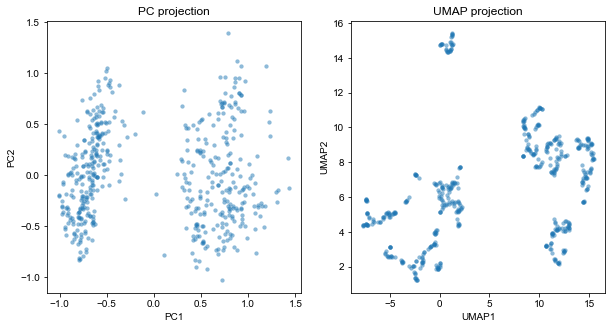

In [6]:
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']

_=sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=0.5, linewidth=0.25,
                  edgecolor='face', ax=ax[0]).set_title("PC projection")

_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=0.5, linewidth=0.25,
                  edgecolor='face', ax=ax[1]).set_title("UMAP projection")


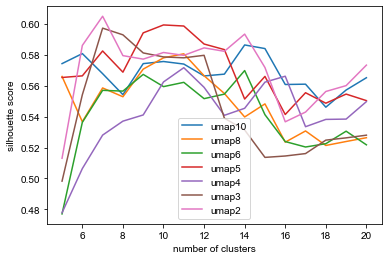

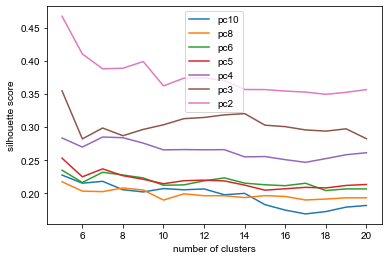

In [7]:
N_CLS_list = list(range(5, 21))
def silhouette_scores_hierarchical(data, n_cls_list):
    
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)

_=silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(xlabel='number of clusters',
                                                                             ylabel='silhouette score')

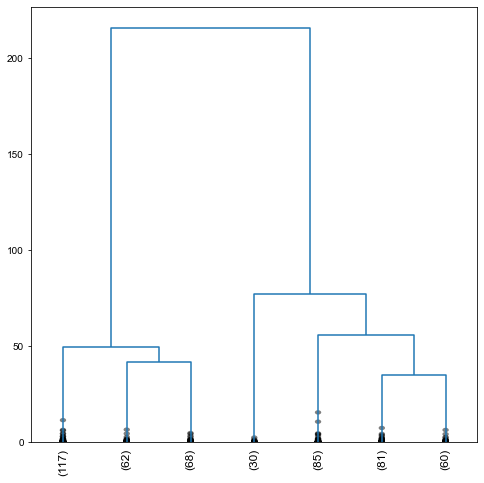

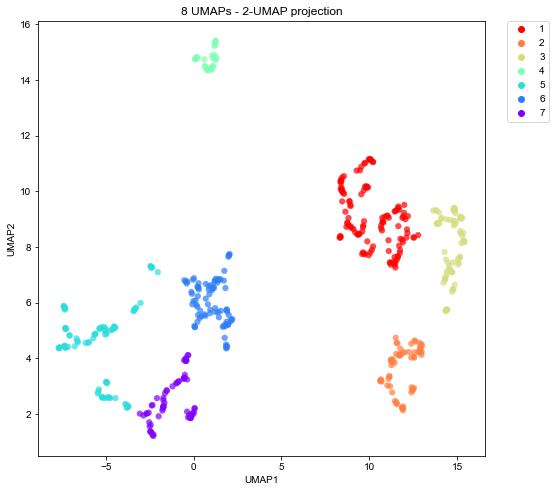

In [8]:
NCLS = 7
n_umap = "umap2"
z = linkage(dfs[n_umap], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True,
             leaf_rotation=90, color_threshold=0)

plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
                palette='rainbow_r', legend='full', hue=cls).set_title("8 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

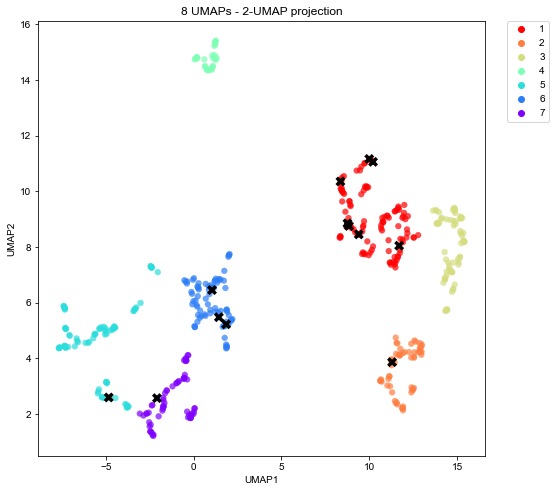

In [9]:
z = linkage(dfs[n_umap], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
                palette='rainbow_r', legend='full', hue=cls).set_title("8 UMAPs - 2-UMAP projection")

# Plot black circles for rows in indices
for index in indices:
    row = dfs['umap2'].iloc[index]  # Assuming you want to use the 'umap2' DataFrame
    plt.scatter(row["UMAP1"], row["UMAP2"], s=100,marker='X', facecolors='black', edgecolors='none')

_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster

# Assuming normalized_df and other variables are defined

z = linkage(dfs[n_umap], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# Add cluster numbers to normalized_df as a new column
normalized_df['Cluster'] = cls

display(normalized_df)

,Compound_Name,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,ω_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,...,Hirsh_atom_dipole_N_low_E,Hirsh_charge_C_low_E,Hirsh_charge_N_low_E,NBO_charge_Havg_low_E,distance_N_Havg(Å)_low_E,Hirsh_CM5_charge_Havg_low_E,Hirsh_atom_dipole_Havg_low_E,Hirsh_charge_Havg_low_E,NMR_shift_Havg_low_E,Cluster
0,alln_10,COCc1cccc(N)c1,0.791477,0.697930,0.389503,0.810651,0.114320,0.396301,0.431912,0.110784,...,0.539755,0.279411,0.391966,0.399770,0.278075,0.489215,0.562530,0.497924,0.626363,1
1,alln_105,COc1ccc(OC)c(N)c1,0.920800,0.724585,0.339671,0.910032,0.067188,0.457136,0.466874,0.176778,...,0.522586,0.240978,0.400560,0.517919,0.255862,0.497515,0.514413,0.445495,0.594791,1
2,alln_115,COc1ccc(N)cc1OC,0.904122,0.646169,0.288749,0.834313,0.120538,0.412886,0.357984,0.186792,...,0.604832,0.220614,0.320506,0.346226,0.358700,0.427321,0.510662,0.443306,0.661528,1
3,alln_146,NCc1ccccc1,0.435121,0.604017,0.511166,0.519632,0.271961,0.287363,0.311771,0.141152,...,0.951624,0.046564,0.051829,0.054451,0.899218,0.098284,0.200468,0.165358,0.934685,6
4,alln_16,Cc1ccc(N)cc1,0.811649,0.663402,0.352141,0.793697,0.131970,0.382882,0.329734,0.162018,...,0.563018,0.256940,0.365356,0.380311,0.305224,0.466751,0.543884,0.478419,0.642464,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,alln_94,COc1cnc(Cl)nc1N,0.541390,0.511840,0.382960,0.505591,0.319896,0.433356,0.371859,0.685641,...,0.236030,0.538359,0.677541,0.807095,0.066228,0.839593,0.814097,0.749996,0.456940,2
499,alln_95,COc1ccc(N)c(OC)c1,0.975026,0.717642,0.304917,0.936502,0.058564,0.445747,0.466192,0.111145,...,0.609765,0.167603,0.303905,0.439778,0.360757,0.408790,0.440168,0.368018,0.636615,1
500,alln_96,COC(=O)c1cnc(N)nc1C,0.444289,0.427163,0.370917,0.376723,0.426193,0.531130,0.468294,0.186897,...,0.205410,0.728400,0.665876,0.758264,0.054710,0.857178,0.862553,0.774954,0.438079,2
501,alln_98,N#Cc1cccc(N)c1,0.540692,0.351723,0.260870,0.370846,0.477537,0.455479,0.351859,0.676208,...,0.465416,0.312264,0.473700,0.487823,0.216783,0.607084,0.671146,0.610544,0.604465,1


In [11]:
# Filter rows where Cluster is equal to 3
cluster_2_rows = normalized_df[normalized_df['Cluster'] == 2]
cluster_3_rows = normalized_df[normalized_df['Cluster'] == 3]
cluster_4_rows = normalized_df[normalized_df['Cluster'] == 4]
cluster_5_rows = normalized_df[normalized_df['Cluster'] == 5]
cluster_6_rows = normalized_df[normalized_df['Cluster'] == 6]
cluster_7_rows = normalized_df[normalized_df['Cluster'] == 7]


# display(cluster_2_rows)
display(cluster_7_rows)

,Compound_Name,smiles,HOMO_low_E,LUMO_low_E,η_low_E,μ_low_E,ω_low_E,polar_aniso(Debye)_low_E,polar_iso(Debye)_low_E,dipole(Debye)_low_E,...,Hirsh_atom_dipole_N_low_E,Hirsh_charge_C_low_E,Hirsh_charge_N_low_E,NBO_charge_Havg_low_E,distance_N_Havg(Å)_low_E,Hirsh_CM5_charge_Havg_low_E,Hirsh_atom_dipole_Havg_low_E,Hirsh_charge_Havg_low_E,NMR_shift_Havg_low_E,Cluster
17,alln_2003,NCC1CCCC1,0.414687,0.905839,0.753117,0.760674,0.081027,0.088226,0.254627,0.164530,...,0.995142,0.037820,0.036900,0.028162,0.838749,0.076118,0.179245,0.140136,0.955478,7
42,alln_119,CC(C)CCN,0.400105,0.887367,0.746906,0.736492,0.094264,0.051606,0.212662,0.150608,...,0.995066,0.040064,0.044722,0.031426,0.831756,0.073133,0.172840,0.136172,0.976895,7
44,alln_120,COCCN,0.376615,0.949541,0.807216,0.774663,0.066787,0.047679,0.097028,0.259718,...,0.993458,0.032103,0.025066,0.087206,0.897984,0.107378,0.184990,0.145567,0.939440,7
45,alln_121,CCOC(=O)CN,0.250611,0.791780,0.754967,0.567268,0.185519,0.136879,0.168112,0.229547,...,0.933331,0.036854,0.074853,0.173264,0.852324,0.234540,0.329241,0.266567,0.917065,7
50,alln_128,COC(=O)CCN,0.374083,0.780374,0.679200,0.631234,0.163057,0.122520,0.165855,0.157564,...,0.986903,0.046353,0.024809,0.209827,0.830934,0.103973,0.152708,0.127153,0.867896,7
53,alln_130,COC(=O)CN,0.235330,0.780374,0.754540,0.548598,0.196751,0.100999,0.092939,0.201691,...,0.928750,0.039536,0.078961,0.175379,0.853147,0.238808,0.333713,0.271208,0.916918,7
54,alln_132,CC(=CCN)C,0.497468,0.798661,0.626191,0.720058,0.122343,0.198727,0.221045,0.174684,...,0.974904,0.032618,0.031071,0.028223,0.905389,0.066879,0.185389,0.139241,0.971488,7
63,alln_141,NCc1ccco1,0.559553,0.735867,0.544450,0.704353,0.146410,0.183929,0.188566,0.150213,...,0.934014,0.049132,0.059683,0.101348,0.858083,0.157620,0.256843,0.205879,0.914209,7
64,alln_142,NC[C@@H]1CCCO1,0.449267,0.937639,0.758665,0.807946,0.057160,0.083154,0.207496,0.276559,...,0.998760,0.016157,0.021593,0.098689,0.912793,0.109195,0.179777,0.146816,0.922988,7
65,alln_143,NC[C@H]1CCCO1,0.449267,0.937639,0.758665,0.807946,0.057160,0.083150,0.207494,0.276536,...,0.998782,0.016153,0.021601,0.098628,0.912382,0.109241,0.179842,0.146854,0.923005,7


# FIGURES

In [12]:
ims = [10, 8, 6, 5, 4, 3, 2]
dfs = {}
df = X  # Assuming 'X' represents your data

n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(umap.UMAP(n_components=dim, n_neighbors=n_neighbors, 
                                      random_state=0).fit_transform(df))

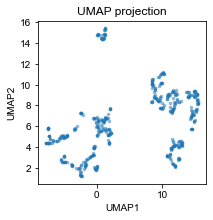

In [13]:
plt.figure(figsize=(3, 3))  # Adjusting figure size
dfs['umap2'].columns = ['UMAP1', 'UMAP2']

_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=10, alpha=0.5, linewidth=0.25,
                    edgecolor='face').set_title("UMAP projection")

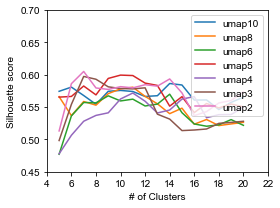

In [14]:
N_CLS_list = list(range(5, 21))

def silhouette_scores_hierarchical(data, n_cls_list):
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

silh_scores = pd.DataFrame(index=N_CLS_list)

for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)

# display(silh_scores)
############
plt.figure(figsize=(4, 3))  
for column in silh_scores.columns:
    plt.plot(N_CLS_list, silh_scores[column], label=column)

x_values = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
plt.xticks(x_values)  # Set x-axis values from 2 to 20
y_values = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70]  # Sample y-axis values
plt.yticks(y_values)

plt.xlabel('# of Clusters')
plt.ylabel('Silhouette score')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig("am-silh.png", dpi=300, bbox_inches='tight')
plt.show()

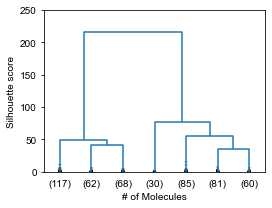

In [15]:
NCLS = 7
n_umap = "umap2"
z = linkage(dfs[n_umap], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

plt.figure(figsize=(3.88, 3))
dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True,
           leaf_rotation=0, color_threshold=0)

# Adjust the leaf font size to Arial 10
plt.tick_params(axis='x', labelsize=10, labelrotation=0)
y_values = [0, 50, 100, 150, 200, 250]
plt.yticks(y_values)
plt.xlabel('# of Molecules')
plt.ylabel('Silhouette score')

plt.tight_layout()
# plt.savefig("am-clust.png", dpi=300, bbox_inches='tight')
plt.show()

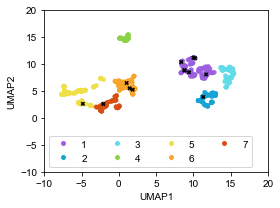

In [16]:
z = linkage(dfs[n_umap], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

custom_palette = ['#9b5fe0', '#16a4d8', '#60dbe8', '#8bd346', '#efdf48', '#f9a52c', '#d64e12']
plt.figure(figsize=(4, 3))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=20, alpha=0.9, linewidth=0.25, edgecolor='face',
                palette=custom_palette, legend=True, hue=cls)

# Plot black circles for rows in indices
for index in indices:
    row = dfs['umap2'].iloc[index]  # Assuming you want to use the 'umap2' DataFrame
    plt.scatter(row["UMAP1"], row["UMAP2"], s=20,marker='X', facecolors='black', edgecolors='none')

# Custom legend
legend_labels = [f'{i}' for i in range(1, NCLS + 1)]  # Adjust the labels as needed
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[i]) for i in range(NCLS)]
plt.legend(legend_handles, legend_labels, loc="lower left", fontsize=10, ncol=4)

x_values = [-10,-5, 0, 5, 10, 15, 20]
plt.xticks(x_values)  # Set x-axis values from 2 to 20
y_values = [-10,-5, 0, 5, 10, 15, 20]
plt.yticks(y_values)

plt.tight_layout()
# plt.savefig("am-umap.png", dpi=300, bbox_inches='tight')
plt.show()

# EXPORT UMAP COORDINATES

In [21]:
# Convert the UMAP coordinates to a DataFrame
umap_df = pd.DataFrame(dfs['umap2'], columns=['UMAP1', 'UMAP2'])

# Export the DataFrame to a excel file
# umap_df.to_excel('amine_umap_coordinates.xlsx', index=False)